In [1]:
import torch
from torch.utils.data import DataLoader
# from torch.utils.data import TensorDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

c:\Users\tothm\.conda\envs\ai_learn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] A megadott eljárás nem található'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Getting the datasets
train_ds = MNIST(root='data', train=True, download=True, transform=ToTensor())
valid_ds = MNIST(root='data', train=False, download=True, transform=ToTensor())

5


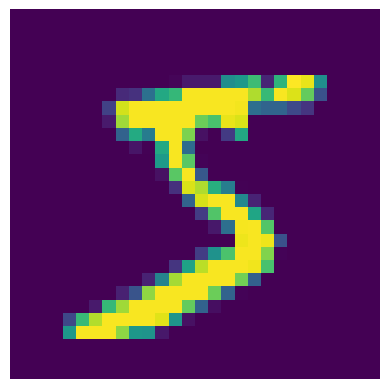

In [3]:
image, label = train_ds[0]
print(label)
plt.axis('off')
plt.imshow(image.float().reshape(28, 28), cmap='viridis')

In [4]:
# Create data loader 
# GPU acceleration -> num_workers, pin_memory (faster ram to gpu transfer)
bs = 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

In [5]:
from torch import nn

# build model
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.lin = nn.Linear(28 * 28, 10)
        self.lin = nn.Linear(784, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 10)

    def forward(self, xb):
        xb = xb.flatten(1, -1) # (bs, 1, 28, 28) -> (bs, 784)
        # return self.lin(xb)
        xb = self.lin(xb)
        xb = self.lin2(xb)
        return self.lin3(xb)

# init model
model = MNISTModel()
print(model)

MNISTModel(
  (lin): Linear(in_features=784, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=10, bias=True)
)


In [6]:
from torch import optim

lr = 0.1

# define a loss func & optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) # method of gradient descent (or Adam) learning rate

# accuracy func for logging
def accuracy_func(pred, yb):
    pred_class = torch.argmax(pred, dim=1)
    return (pred_class == yb).float().mean()

In [7]:
# Create the trainer
def train(dataloader, model, loss_func, optimizer):
    for batch_idx, (xb, yb) in enumerate(dataloader): # take input and label from data loader
        
        # loss
        pred = model(xb)
        loss = loss_func(pred, yb)

        # backprop
        loss.backward() # autograd
        optimizer.step() # updates the parameters using the optimizer we provided
        optimizer.zero_grad() # wipe the gradients for the next it

        # logging
        if batch_idx % 100 == 0:
            train_loss, train_accuracy = loss.item(), accuracy_func(pred, yb).item() * 100
            print(f'Loss: {train_loss:6f} Accuracy: {train_accuracy:0.1f}%')

In [8]:
# Define test
def test(dataloader, model, loss_func):
    model.eval() # flag to make sure things like dropout works as expected in testing
    with torch.no_grad(): # because not updating
        for xb, yb in dataloader:
            pred = model(xb)
            loss = loss_func(pred, yb)
            accuracy = accuracy_func(pred, yb)

            test_loss, test_accuracy = loss.item(), accuracy.item() * 100
    print(f'Test:\n Loss: {test_loss:6f} Accuracy: {test_accuracy:0.1f}%')

In [9]:
# RUN

epochs = 2

for t in range(epochs):
    print(f'\nEpoch {t}\n-----------------')
    train(train_dl, model, loss_func, optimizer)
    test(valid_dl, model, loss_func)
print('\nFinished!')


Epoch 0
-----------------


Loss: 2.309981 Accuracy: 6.2%
Loss: 0.628152 Accuracy: 78.1%
Loss: 0.286497 Accuracy: 90.6%
Loss: 0.356064 Accuracy: 90.6%
Loss: 0.546962 Accuracy: 89.1%
Loss: 0.470145 Accuracy: 84.4%
Loss: 0.506108 Accuracy: 81.2%
Loss: 0.385837 Accuracy: 85.9%
Loss: 0.410232 Accuracy: 85.9%
Loss: 0.350843 Accuracy: 87.5%
Test:
 Loss: 0.371498 Accuracy: 87.5%

Epoch 1
-----------------
Loss: 0.296178 Accuracy: 89.1%
Loss: 0.370028 Accuracy: 87.5%
Loss: 0.603831 Accuracy: 81.2%
Loss: 0.248864 Accuracy: 90.6%
Loss: 0.335649 Accuracy: 89.1%
Loss: 0.334939 Accuracy: 90.6%
Loss: 0.270145 Accuracy: 90.6%
Loss: 0.262928 Accuracy: 92.2%
Loss: 0.230455 Accuracy: 92.2%
Loss: 0.225803 Accuracy: 92.2%
Test:
 Loss: 0.077831 Accuracy: 100.0%

Finished!


Noise:  [ 0.84838915 -9.121184    7.3805785  10.095431   -9.395775    8.446102
 -7.0597467  -1.1934965   7.0960765  -2.534281  ]
Noise result =  3
Dataset:  [ 1.9137024 -8.221228   2.411082   5.841603  -1.3390603  1.792247
 -9.179934  12.826225   0.8813311  4.612034 ]
Dataset result =  7


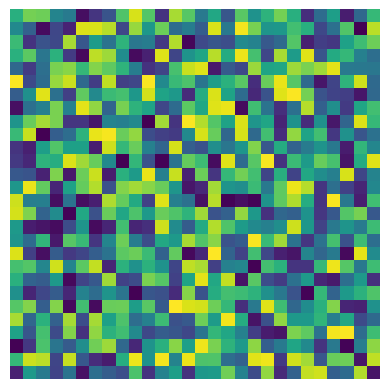

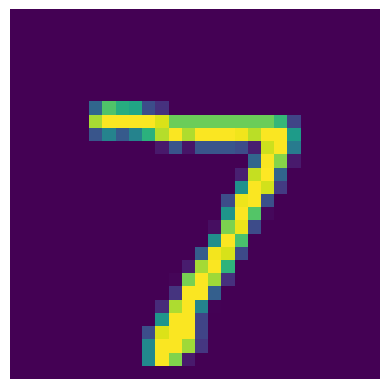

In [10]:
# Generate a noise image and run prediction
import numpy as np

sample = (255 * np.random.random(784)).astype('uint8').reshape((28, 28))
preprocessed_sample = ToTensor()(sample)

image_ds, label_ds = valid_ds[0]

model.eval()
with torch.no_grad():
    pred_noise = model(preprocessed_sample.unsqueeze(0).float()).numpy()[0]
    print('Noise: ', pred_noise)
    print('Noise result = ', np.argmax(pred_noise))

    pred_ds = model(image_ds).numpy()[0]
    print('Dataset: ', pred_ds)
    print('Dataset result = ', np.argmax(pred_ds))

plt.axis('off')
plt.imshow(sample, cmap='viridis')
plt.show()
plt.axis('off')
plt.imshow(image_ds.float().reshape(28, 28), cmap='viridis')